In [1588]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import datetime 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Считываем страницу student_1

In [786]:
df = pd.read_excel('data.xlsx')
df.head()

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,service_status,service_quantity,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level
0,2022-02-28 22:36:30,delivered,7f2a9c90-1599-42a4-871d-b6cfc5349f24,49,False,176587,True,0,0,0,...,0,1,0fc1c709c57b84c756e2347fc5dda380,a3dd97667c8f2bb47a7391c769e2e868,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,a3dd97667c8f2bb47a7391c769e2e868,3
1,2022-02-28 22:29:36,delivered,796f3150-a8a7-40e8-b906-13b531de7bcf,44,False,177711,True,0,0,0,...,0,1,b602362c2a586c560131d97cf5b14075,195dc214249dab3c31906b4b9f83d503,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,195dc214249dab3c31906b4b9f83d503,b602362c2a586c560131d97cf5b14075,3
2,2022-02-28 22:15:39,delivered,a48c27f7-d645-4b49-bc49-37302b406e1c,107,False,76776,True,0,0,23,...,0,1,44d7c109bf5552287fd73a30ded5d6d6,883df3cf6bc90d69afb61c2fe31be838,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,883df3cf6bc90d69afb61c2fe31be838,3
3,2022-02-28 22:15:39,delivered,a48c27f7-d645-4b49-bc49-37302b406e1c,107,False,76776,True,0,0,23,...,0,1,746da6d65d78980c617eb8ead13a74a4,bb04f5f7eeb7aa2ca785b724a1c16752,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,bb04f5f7eeb7aa2ca785b724a1c16752,3
4,2022-02-28 21:47:08,not_delivered,482b781f-a376-4978-a712-bf0ad5fd1d30,94,False,105692,True,27,0,0,...,0,1,867de31618ddaf86ccdc872f60203135,6b4bc42634c38300eb38251b1356f64e,5d7247c6609e95d4180a71551b9d8d59,92a54b358b4cf53cca4095e4697e1004,63a9f0ea7bb98050796b649e85481845,92a54b358b4cf53cca4095e4697e1004,5d7247c6609e95d4180a71551b9d8d59,4


In [787]:
df.shape

(547868, 24)

Преобразуем дату в единый формат:

In [788]:
df[['created_at']].dtypes

created_at    datetime64[ns]
dtype: object

In [789]:
df['created_at'] = df['created_at'].dt.date

Считываем страницу с убытками

In [1637]:
t = pd.read_excel('data.xlsx', sheet_name='описание')

In [1638]:
t

,created_at,дата создания письма гарантийного
0,status,статус гарантийного письма
1,guarant_letter_uuid,ID гарантийного письма
2,comment_len,длина комментария
3,is_paid_by_patient,оплачено было ли клиентом
4,patient_id,ID пациента
5,has_doctor,есть ли комментарий доктора
6,doctor_len,длина комментария
7,diagnosis_len,длина диагноза
8,diagnosis_clarification_len,длина диагноза детальнее
9,standartized_diagnosis_len,cтандартизированный диагноз


In [790]:
target = pd.read_excel('data.xlsx', sheet_name='убытки(целевая переменная)')

In [791]:
target.head()

,patient_id,дата убытка,loss
0,70772,2021-12-14,4.743
1,48418,2021-11-22,3.200
2,147869,2021-09-11,1.350
3,109626,2021-04-29,6.520
4,47870,2021-10-04,1.322


In [792]:
target = target.rename(columns={'дата убытка': 'date'})

In [793]:
target.shape

(464181, 3)

In [794]:
target.dtypes

patient_id             int64
date          datetime64[ns]
loss                 float64
dtype: object

Преобразуем дату и тут:

In [795]:
target['date'] = target['date'].dt.date

Соединяем данные в одну таблицу. Оставляем только тех пациентов, записи о которых есть в обоих таблицах (причем даты тоже должны совпадать)

In [1596]:
result = pd.merge(df, target, how="inner", left_on=['patient_id', 'created_at'], right_on=['patient_id', 'date'])

In [1597]:
result.head()

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,date,loss
0,2022-02-28,delivered,7f2a9c90-1599-42a4-871d-b6cfc5349f24,49,False,176587,True,0,0,0,...,0fc1c709c57b84c756e2347fc5dda380,a3dd97667c8f2bb47a7391c769e2e868,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,a3dd97667c8f2bb47a7391c769e2e868,3,2022-02-28,5.6800
1,2022-02-28,delivered,fd747e32-0ee2-4418-84ba-e78216119ed5,301,False,85675,True,0,21,0,...,c1babc7cb238ab308da4b0a23fd604b2,NaN,63a9f0ea7bb98050796b649e85481845,NaN,NaN,b95c3d50fa47443166f7d356eaed8006,c1babc7cb238ab308da4b0a23fd604b2,2,2022-02-28,8.6165
2,2022-02-28,delivered,56344847-915f-4c42-adfe-18ac503c77cb,172,False,85675,True,0,46,0,...,993478970b98d4a20bf91e64aad312bd,b95c3d50fa47443166f7d356eaed8006,NaN,63a9f0ea7bb98050796b649e85481845,NaN,b95c3d50fa47443166f7d356eaed8006,993478970b98d4a20bf91e64aad312bd,3,2022-02-28,8.6165
3,2022-02-28,delivered,f42bde97-07a1-4235-93e9-7abfed0f398f,77,False,192505,True,0,0,0,...,431d09a75b317feddeffee19652edf60,f55e86c273940887727c2620ec18190f,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,f55e86c273940887727c2620ec18190f,3,2022-02-28,2.6000
4,2022-02-28,not_delivered,1c4de961-c862-47cc-aaca-30876cd55134,59,False,159670,True,0,0,0,...,0896fe692fbd93c5b34112bb28bf6a85,a8fa6b553b655657f943cb8fd85859d1,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,a8fa6b553b655657f943cb8fd85859d1,0896fe692fbd93c5b34112bb28bf6a85,3,2022-02-28,2.6672


In [1598]:
result = result.drop(columns=['date'])

In [1599]:
result.shape

(199808, 25)

Считаем для каждого клиента сумму всех убытков за месяц

In [1600]:
result = result.sort_values('created_at')

In [1601]:
result['per_month'] = np.nan
result['per_week'] = np.nan
result['target'] = np.nan

In [1602]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [1603]:
from dateutil import rrule
def weeks_between(start_date, end_date):
    weeks = rrule.rrule(rrule.WEEKLY, dtstart=start_date, until=end_date)
    return weeks.count()

In [1609]:
temp = result.drop_duplicates(subset=["guarant_letter_uuid"], keep='first')

In [1610]:
temp = temp.drop_duplicates(subset=["created_at", 'patient_id'], keep='first')

In [1611]:
temp['per_month'] = 1
temp['per_week'] = 1
temp['target'] = 0

In [1612]:
for i in temp['patient_id'].unique():
    date = temp.loc[temp['patient_id'] == i, 'created_at']
    for j in date.index:
        summ = temp.loc[j, 'loss']
        for k in date.index:
            if abs(diff_month(date[j], date[k])) <= 1 and j != k:
                temp.loc[j, 'per_month'] += 1
                summ += temp.loc[k, 'loss']
                if abs(weeks_between(date[j], date[k]) <= 1):
                    temp.loc[j, 'per_week'] += 1
            temp.loc[j, 'target'] = summ

In [1613]:
temp.head()

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,per_month,per_week,target
198974,2020-07-01,created,5e7ea5a8-6767-4082-a026-44f43ddb57f9,104,False,44227,True,0,52,0,...,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,bb04f5f7eeb7aa2ca785b724a1c16752,3,3.4240,4,3,14.3640
198984,2020-07-01,created,84718b98-e226-4cd2-92a7-6d4d2ad73a63,46,False,40903,True,0,28,0,...,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,883df3cf6bc90d69afb61c2fe31be838,3,5.1452,1,1,5.1452
198985,2020-07-01,created,b831214c-affa-4b47-8eb6-825941e1e2dd,31,False,44974,True,0,109,0,...,a24e26abe7d3a3fbd823fcbc34f32830,29e72acb32dec80d0e231748af6f5a28,2622e9b348f05f74e3e4bb9b7d213dc8,2622e9b348f05f74e3e4bb9b7d213dc8,29e72acb32dec80d0e231748af6f5a28,5,3.4580,1,1,3.4580
198986,2020-07-01,created,49b88473-5955-4894-81e8-b878f11e7ace,190,False,45562,True,0,203,0,...,92a54b358b4cf53cca4095e4697e1004,63a9f0ea7bb98050796b649e85481845,NaN,92a54b358b4cf53cca4095e4697e1004,1349bbcd6601ad1b114288db7664954c,3,4.8000,2,2,9.6000
198990,2020-07-01,created,93f8a415-e973-47c3-bc2c-def48e095a9c,161,False,39968,True,0,83,0,...,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,195dc214249dab3c31906b4b9f83d503,31842b3c8985ce35e9f07d4ed759cb44,3,4.0000,4,2,16.4500


In [1614]:
result = result.combine_first(temp)

In [1615]:
for i in result['patient_id'].unique():
    date = temp.loc[temp['patient_id'] == i, 'created_at']
    for j in date.values:
        result.loc[(result['patient_id'] == i) & (result['created_at'] == j), 'per_month'] = temp.loc[(temp['patient_id'] == i) & (temp['created_at'] == j), 'per_month'].values[0]
        result.loc[(result['patient_id'] == i) & (result['created_at'] == j), 'per_week'] = temp.loc[(temp['patient_id'] == i) & (temp['created_at'] == j), 'per_week'].values[0]
        result.loc[(result['patient_id'] == i) & (result['created_at'] == j), 'target'] = temp.loc[(temp['patient_id'] == i) & (temp['created_at'] == j), 'target'].values[0]

Рассчитываем кол-во уникальных значений, нулевых и пустых значений + доля в % от общего кол-ва

In [1318]:
unique = []
unique_per = []
j = 0
for i in result.columns:
    unique.append(result[i].nunique())
    unique_per.append(100 * unique[j] / result[i].shape[0])
    j += 1

In [1319]:
pd.DataFrame(data=[unique] + [unique_per], 
                      columns=result.columns,
                     index=['Кол-во уникальных значений', 'Доля уникальных значений % от общего кол-ва'])

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,per_month,per_week,target
Кол-во уникальных значений,166.000,5.00,15763.000,722.000,1.000,8599.000,1.000,65.00,155.00,298.000,...,118.000,21.000,9.000,38.000,486.000,6.000,3839.000,12.000,12.000,4429.000
Доля уникальных значений % от общего кол-ва,0.332,0.01,31.526,1.444,0.002,17.198,0.002,0.13,0.31,0.596,...,0.236,0.042,0.018,0.076,0.972,0.012,7.678,0.024,0.024,8.858


In [1320]:
print(result['is_paid_by_patient'].unique())
print(result['has_doctor'].unique())

[False]
[ True]


Выше видно, что признаки has_doctor и is_paid_by_patient принимают на всем датасете одно значение, удаляем их

In [1321]:
result = result.drop(columns=['is_paid_by_patient', 'has_doctor'])

In [1322]:
null = []
null_per = []
j = 0
for i in result.columns:
    null.append((result[i] == 0).sum())
    null_per.append(100 * null[j] / result[i].shape[0])
    j += 1

In [1323]:
pd.DataFrame(data=[null] + [null_per], 
                      columns=result.columns,
                     index=['Кол-во нулевых значений', 'Доля нулевых значений % от общего кол-ва'])

,created_at,status,guarant_letter_uuid,comment_len,patient_id,doctor_len,diagnosis_len,diagnosis_clarification_len,standartized_diagnosis_len,diagnosis_uuid,...,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,per_month,per_week,target
Кол-во нулевых значений,0.0,0.0,0.0,2859.000,0.0,35597.000,48397.000,40774.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Доля нулевых значений % от общего кол-ва,0.0,0.0,0.0,5.718,0.0,71.194,96.794,81.548,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Много нулевых значений замечано у признаков doctor_len, diagnosis_clarification_len, service_status. Для service_status это нормально, так как там 0 - это одобрение. Длина тоже может быть нулевой

In [1324]:
empty = []
empty_per = []
j = 0
for i in result.columns:
    empty.append(result[i].isna().sum())
    empty_per.append(100 * empty[j] / result[i].shape[0])
    j += 1

In [1328]:
pd.DataFrame(data=[empty] + [empty_per], 
                      columns=result.columns,
                     index=['Кол-во пустых значений', 'Доля пустых значений % от общего кол-ва'])

,created_at,status,guarant_letter_uuid,comment_len,patient_id,doctor_len,diagnosis_len,diagnosis_clarification_len,standartized_diagnosis_len,diagnosis_uuid,...,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,per_month,per_week,target
Кол-во пустых значений,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1411.000,1411.000,...,527.000,2110.00,31873.000,762.000,762.000,0.0,0.0,0.0,0.0,0.0
Доля пустых значений % от общего кол-ва,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.822,2.822,...,1.054,4.22,63.746,1.524,1.524,0.0,0.0,0.0,0.0,0.0


У признака folk_4_code большое количество пропущенных значений. Удалим его
В остальных пропусках для численных переменных поставим вместо пропусков среднее значение, для категориальных - часто встречающееся

In [1329]:
result = result.drop(columns=['folk_4_code'])

In [1330]:
for i in result.columns:
    print(i, result[i].isna().sum())

created_at 0
status 0
guarant_letter_uuid 0
comment_len 0
patient_id 0
doctor_len 0
diagnosis_len 0
diagnosis_clarification_len 0
standartized_diagnosis_len 1411
diagnosis_uuid 1411
diagnosis_category_level_3_hash 1411
diagnosis_category_level_1_hash 1411
service_status 0
service_quantity 0
service_code 762
folk_1_code 196
folk_2_code 527
folk_3_code 2110
service_level_3_category_hash 762
service_level_2_category_hash 762
service_level 0
loss 0
per_month 0
per_week 0
target 0


In [1335]:
categorical = ['diagnosis_uuid', 'service_code', 'folk_1_code', 'folk_2_code', 'folk_3_code',
              'service_level_3_category_hash', 'service_level_2_category_hash',
              'diagnosis_category_level_3_hash', 'diagnosis_category_level_1_hash']
numeric = ['standartized_diagnosis_len']

In [1336]:
mode_r = []
for i in categorical:
    mode_r.append(result[i].mode()[0])

In [1337]:
pd.DataFrame(data=[mode_r], 
                      columns=categorical,
                     index=['Мода'])

,diagnosis_uuid,service_code,folk_1_code,folk_2_code,folk_3_code,service_level_3_category_hash,service_level_2_category_hash,diagnosis_category_level_3_hash,diagnosis_category_level_1_hash
Мода,0722beb1-f1a9-4776-80d2-b94b96a143c4,82c66a68ed841e90e3f3ba52bbe6d08b,883df3cf6bc90d69afb61c2fe31be838,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,c951270e425b15fc20c64da4341c1d89,883df3cf6bc90d69afb61c2fe31be838,d11305db9650c256415e01d62061090a,8d9c307cb7f3c4a32822a51922d1ceaa


In [1338]:
result['diagnosis_uuid'] = result['diagnosis_uuid'].fillna('0722beb1-f1a9-4776-80d2-b94b96a143c4')
result['service_code'] = result['service_code'].fillna('82c66a68ed841e90e3f3ba52bbe6d08b')
result['folk_1_code'] = result['folk_1_code'].fillna('883df3cf6bc90d69afb61c2fe31be838')
result['folk_2_code'] = result['folk_2_code'].fillna('c951270e425b15fc20c64da4341c1d89')
result['folk_3_code'] = result['folk_3_code'].fillna('63a9f0ea7bb98050796b649e85481845')
result['service_level_3_category_hash'] = result['service_level_3_category_hash'].fillna('c951270e425b15fc20c64da4341c1d89')
result['service_level_2_category_hash'] = result['service_level_2_category_hash'].fillna('883df3cf6bc90d69afb61c2fe31be838')
result['diagnosis_category_level_3_hash'] = result['diagnosis_category_level_3_hash'].fillna('d11305db9650c256415e01d62061090a')
result['diagnosis_category_level_1_hash'] = result['diagnosis_category_level_1_hash'].fillna('8d9c307cb7f3c4a32822a51922d1ceaa')

In [1339]:
for i in numeric:
    result.loc[result[i].isna(), i] = result[i].mean()

In [1621]:
result['count'] = result.groupby('guarant_letter_uuid')['guarant_letter_uuid'].transform('count')

Посмотрим на корреляцию признаков

In [1367]:
correlations = result.corr()
correlations

,status,guarant_letter_uuid,comment_len,patient_id,doctor_len,diagnosis_len,diagnosis_clarification_len,standartized_diagnosis_len,diagnosis_uuid,diagnosis_category_level_3_hash,...,folk_2_code,folk_3_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,per_month,per_week,target,count
status,1.000000,0.005483,0.081313,-0.001503,0.008017,-0.013920,-0.001007,0.004155,0.012833,-0.023306,...,-0.013917,-0.009064,-0.014759,-0.004434,0.011610,-0.035949,0.012364,0.006180,-0.018393,-0.035668
guarant_letter_uuid,0.005483,1.000000,-0.008888,0.000462,0.003169,-0.012646,0.016833,0.011919,0.016870,-0.018424,...,-0.000097,0.002782,0.007902,-0.007290,0.001806,0.002405,0.008961,0.009517,0.006272,0.007622
comment_len,0.081313,-0.008888,1.000000,0.028493,0.026196,0.009665,0.051139,0.046789,-0.045750,-0.071517,...,0.072903,0.088805,0.131048,0.010226,-0.076072,0.033855,-0.042018,-0.065541,-0.003479,0.398127
patient_id,-0.001503,0.000462,0.028493,1.000000,-0.008634,-0.022938,-0.001054,-0.011782,0.002519,-0.040115,...,0.024671,0.012831,0.021806,0.002926,-0.009454,-0.041616,-0.010566,-0.013845,-0.049756,0.064476
doctor_len,0.008017,0.003169,0.026196,-0.008634,1.000000,-0.067000,0.235750,-0.002966,0.043508,-0.028262,...,0.017440,0.005075,0.015109,0.011587,0.025835,0.035753,-0.008644,-0.011516,0.025657,0.010232
diagnosis_len,-0.013920,-0.012646,0.009665,-0.022938,-0.067000,1.000000,-0.042878,0.010645,-0.156554,0.121762,...,-0.046146,0.002419,-0.028898,0.012041,-0.122322,0.038071,-0.010575,-0.007534,0.018654,-0.086236
diagnosis_clarification_len,-0.001007,0.016833,0.051139,-0.001054,0.235750,-0.042878,1.000000,0.020126,0.044914,-0.000872,...,0.023952,-0.035728,-0.004200,0.016199,0.010574,0.091004,0.011509,0.007323,0.048711,0.113242
standartized_diagnosis_len,0.004155,0.011919,0.046789,-0.011782,-0.002966,0.010645,0.020126,1.000000,-0.072793,0.056895,...,0.047241,0.051902,0.062933,0.026363,-0.047629,-0.013945,-0.021046,-0.007750,-0.020033,0.046754
diagnosis_uuid,0.012833,0.016870,-0.045750,0.002519,0.043508,-0.156554,0.044914,-0.072793,1.000000,-0.080328,...,0.001231,-0.099127,-0.056250,-0.007106,0.061310,-0.039946,0.031114,0.033914,-0.004181,-0.034344
diagnosis_category_level_3_hash,-0.023306,-0.018424,-0.071517,-0.040115,-0.028262,0.121762,-0.000872,0.056895,-0.080328,1.000000,...,-0.029006,-0.043066,-0.046096,0.078264,0.027144,0.003264,-0.015234,-0.000551,-0.004193,-0.136260


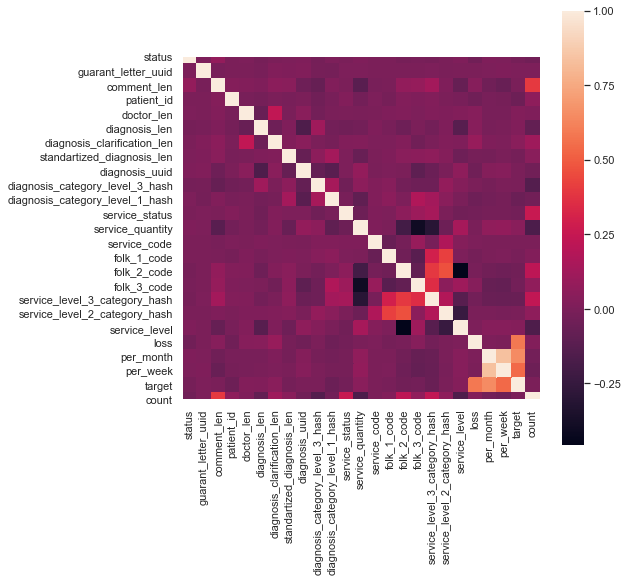

In [1368]:
plt.figure(figsize=(8, 8))
sns.heatmap(correlations, square=True)
plt.show()

Видим, что последние признаки между собой неплохо коррелируют

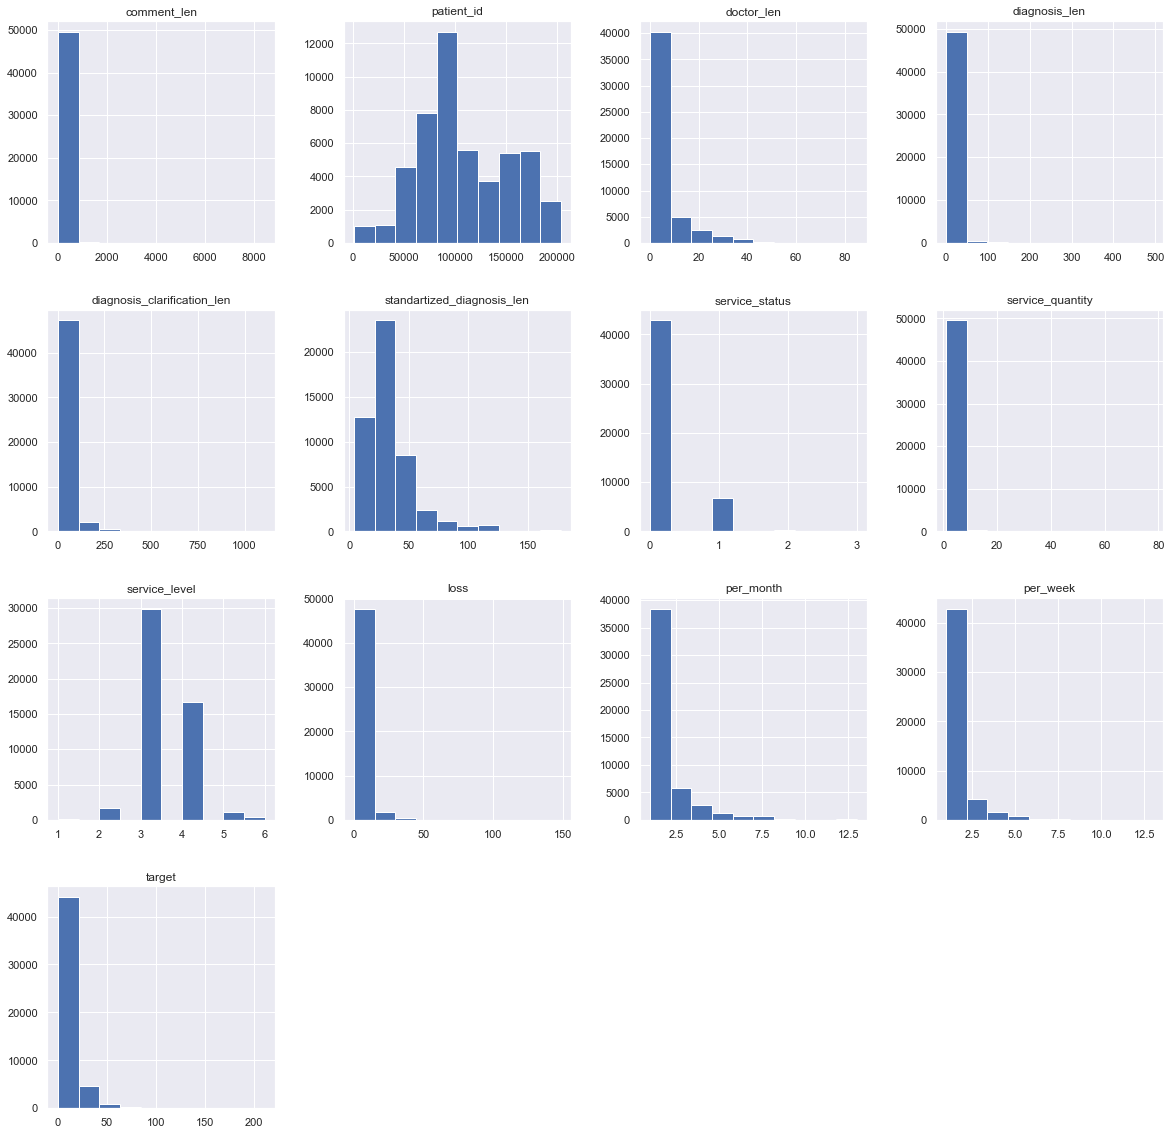

In [1343]:
result.hist(figsize = (20, 20))
plt.show()

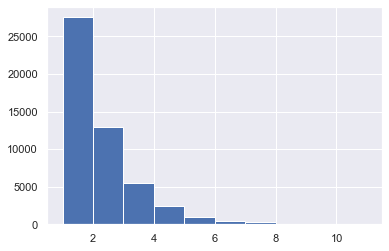

In [1633]:
result['per_week'].hist()
plt.show()

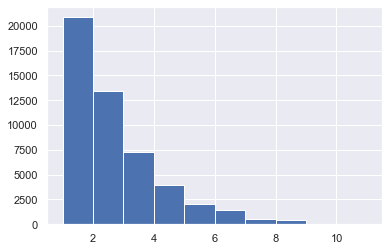

In [1634]:
result['per_month'].hist()
plt.show()

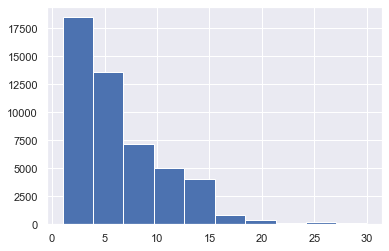

In [1635]:
result['count'].hist()
plt.show()

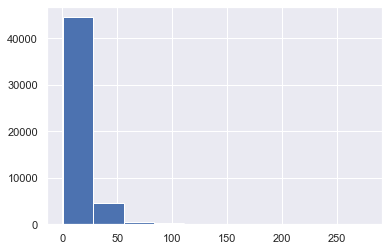

In [1645]:
result['target'].hist()
plt.show()

In [1682]:
pie = pd.DataFrame()

In [1677]:
result.shape[0]

50000

In [1696]:
count = [result.loc[(result['target'] > 0) & (result['target'] <= 10), 'target'].count() / result.shape[0],
                result.loc[(result['target'] > 10) & (result['target'] <= 20), 'target'].count() / result.shape[0],
                result.loc[(result['target'] > 20) & (result['target'] <= 30), 'target'].count() / result.shape[0],
                result.loc[(result['target'] > 30) & (result['target'] <= 40), 'target'].count() / result.shape[0],
                result.loc[(result['target'] > 40) & (result['target'] <= 50), 'target'].count() / result.shape[0],
                result.loc[result['target'] > 50, 'target'].count() / result.shape[0]]

In [1707]:
count

[0.54756, 0.25198, 0.10618, 0.04494, 0.02116, 0.02818]

In [1697]:
names = ['<10', '10-20', '20-30', '30-40', '40-50', '>50']

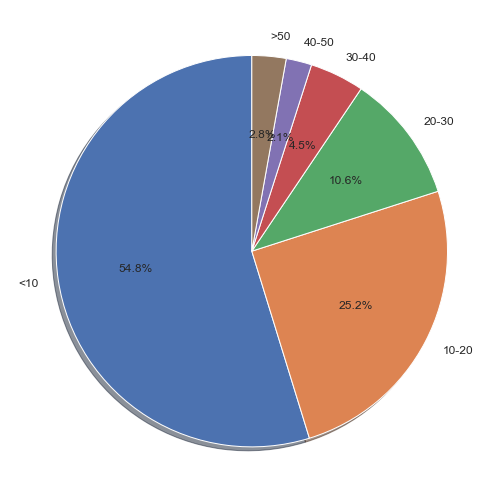

In [1706]:
plt.figure(figsize=(9,9))
plt.pie(count, labels=names, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12})
plt.show()

Переведем признак created_at в численный формат - разница между датой и сегодняшним днем

In [1350]:
from datetime import date

today = date.today()
for i in range(len(result['created_at'])):
    result['created_at'][i] = abs((today - result['created_at'][i]).days)

In [1369]:
categorical = ['guarant_letter_uuid', 'status', 'service_status', 'folk_1_code', 'folk_2_code', 'folk_3_code',
              'service_level_3_category_hash', 'service_level_2_category_hash', 'service_level', 'diagnosis_uuid',
              'diagnosis_category_level_3_hash', 'diagnosis_category_level_1_hash', 'service_code']

In [1353]:
for i in categorical:
    le = LabelEncoder()
    result[i] = le.fit_transform(result[i])

In [1421]:
y = result['target']
X = result.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .30, random_state=1)

##### DecisionTreeRegressor

In [1371]:
cv = KFold(shuffle=True, random_state=241)

gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2', 'sqrt'],
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32],
                  },
                  cv=cv,
                  scoring='r2')

gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=241),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 50],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 4, 8, 32]},
             scoring='r2')

In [1456]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']
cv_grid.head()

,max_depth,max_features,min_samples_leaf,mean_test_score
0,2,auto,1,0.454371
1,2,auto,4,0.454371
2,2,auto,8,0.454371
3,2,auto,32,0.454371
4,2,log2,1,0.197612


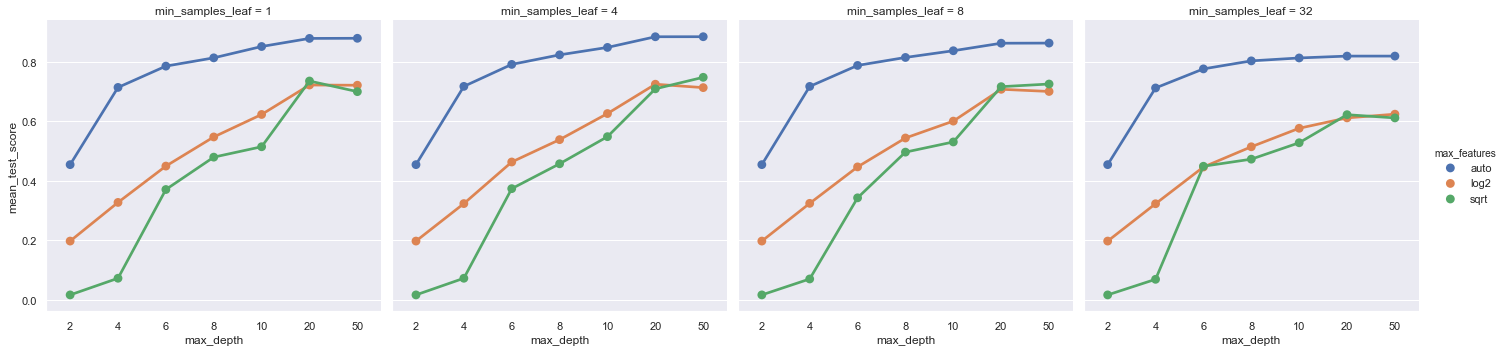

In [1457]:
sns.catplot(x='max_depth', y='mean_test_score', data=cv_grid,
            col='min_samples_leaf', hue='max_features',
            kind='point')

In [1373]:
gs.best_params_

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4}

In [1455]:
gs.best_score_

0.8841060990238686

In [1430]:
dtr = DecisionTreeRegressor(random_state=241, max_depth=50, max_features='auto', min_samples_leaf=4)

In [1431]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=50, max_features='auto', random_state=241)

In [1571]:
y_dtr = dtr.predict(X_test)

In [1572]:
from sklearn.metrics import mean_squared_error
print('RMSE =', mean_squared_error(y_test, y_dtr, squared=False))

RMSE = 3.804141503340635


##### RandomForestRegressor

In [1490]:
cv = KFold(shuffle=True, random_state=241)

gs = GridSearchCV(RandomForestRegressor(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2', 'sqrt'],
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32],
                  },
                  cv=cv,
                  scoring='r2')

gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             estimator=RandomForestRegressor(random_state=241),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 50],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 4, 8, 32]},
             scoring='r2')

In [1491]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']
cv_grid.head()

,max_depth,max_features,min_samples_leaf,mean_test_score
0,2,auto,1,0.571349
1,2,auto,4,0.581617
2,2,auto,8,0.562738
3,2,auto,32,0.480210
4,2,log2,1,0.298922


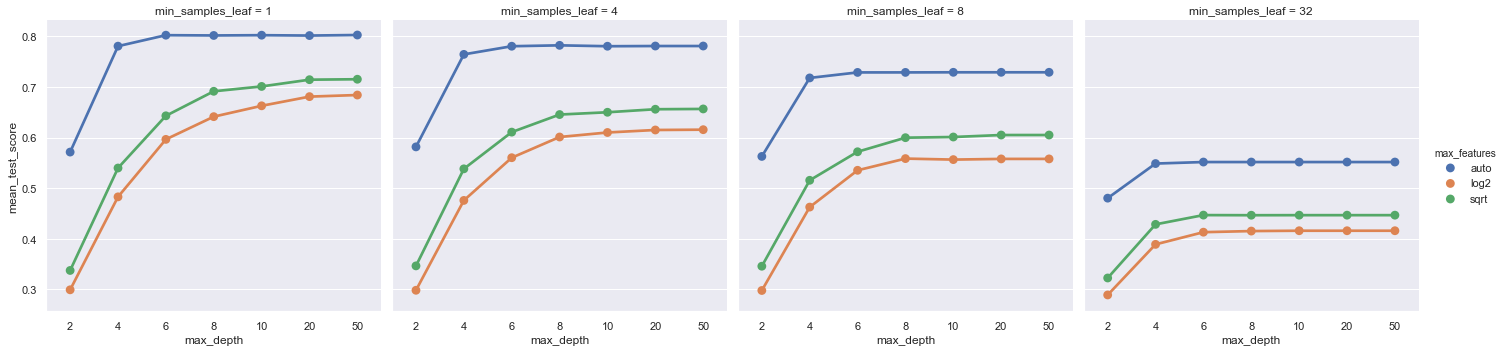

In [1493]:
sns.catplot(x='max_depth', y='mean_test_score', data=cv_grid,
            col='min_samples_leaf', hue='max_features',
            kind='point')

In [1494]:
gs.best_params_

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1}

In [1495]:
gs.best_score_

0.8028801263741642

In [1499]:
rfr = RandomForestRegressor(random_state=241, max_depth=50, max_features='auto', min_samples_leaf=1)

In [1500]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, random_state=241)

In [1578]:
y_rfr = rfr.predict(X_test)

In [1570]:
print('RMSE =', mean_squared_error(y_test, y_rfr, squared=False))

RMSE = 3.0314098410659733


##### CatBoost

In [1511]:
from catboost import CatBoostRegressor

In [1550]:
cv = KFold(shuffle=True, random_state=241)

gs = GridSearchCV(CatBoostRegressor(loss_function='RMSE', logging_level='Silent'),
                  param_grid={
                      'iterations': np.arange(1, 100, 10),
                      'depth': np.arange(1, 10, 2),
                      'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.5, 0.1, 1],
                  },
                  cv=cv,
                  scoring='r2')

gs.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa669dc6b50>,
             param_grid={'depth': array([1, 3, 5, 7, 9]),
                         'iterations': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.5, 0.1,
                                           1]},
             scoring='r2')

In [1551]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']
cv_grid.head()

,depth,iterations,learning_rate,mean_test_score
0,1,1,0.001,-0.007277
1,1,1,0.010,-0.004015
2,1,1,0.020,-0.000417
3,1,1,0.030,0.003151
4,1,1,0.500,0.138300


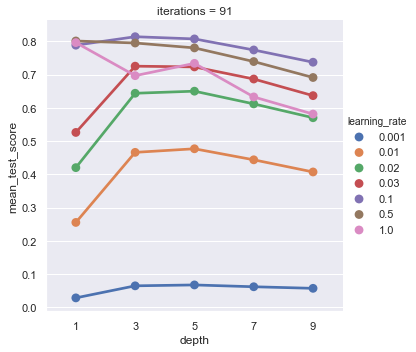

In [1644]:
sns.catplot(x='depth', y='mean_test_score', data=cv_grid[cv_grid['iterations'] == 91],
            col='iterations', hue='learning_rate',
            kind='point')

In [1553]:
gs.best_params_

{'depth': 3, 'iterations': 91, 'learning_rate': 0.1}

In [1554]:
gs.best_score_

0.8143841035597728

In [1560]:
cbr = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', **gs.best_params_)

In [1562]:
cbr.fit(X_train, y_train)

In [1576]:
y_cbr = cbr.predict(X_test)

In [1574]:
print('RMSE =', mean_squared_error(y_test, y_cbr, squared=False))

RMSE = 5.8517310063423364


In [1594]:
models = ['Decision tree', 'Random forest', 'CatBoost']
preds = [y_dtr, y_rfr, y_cbr]
metrics = pd.DataFrame(columns=models)
for i in range(len(models)):
    metrics.loc['RMSE', models[i]] = mean_squared_error(y_test, preds[i], squared=False) 
    metrics.loc['MAE', models[i]] = mean_absolute_error(y_test, preds[i])
    metrics.loc['R2', models[i]] = r2_score(y_test, preds[i])

In [1595]:
metrics

,Decision tree,Random forest,CatBoost
RMSE,3.804142,3.03141,5.851731
MAE,0.589576,0.743685,2.525766
R2,0.902283,0.937949,0.768779
